In [187]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import json
import math
import pickle
import re
from matplotlib import pyplot as plt
from collections import defaultdict
import scipy
%matplotlib inline

In [188]:
with open("./app/irsystem/controllers/TVTropesScraper/Film/Film_tropes_dataset3.json", 'r') as f:
    movie_tropes_data = json.load(f)
with open("./app/irsystem/controllers/TVTropesScraper/Literature/Literature_tropes_dataset3.json", 'r') as f:
    book_tropes_data = json.load(f)

In [189]:
with open("./app/irsystem/controllers/DatasetInfo/book_dataset.json", 'r', encoding='utf-8') as json_file:  
    alena_books = json.loads(json_file.read())
with open("./app/irsystem/controllers/DatasetInfo/movie_dataset.json", 'r', encoding='utf-8') as json_file:  
    alena_movies = json.loads(json_file.read())
movielens_reviews = pickle.load(open("./app/irsystem/controllers/DatasetInfo/movielens_reviews.p", "rb" ))

In [190]:
inverted_index_books = defaultdict(list)
for book, trope_list in book_tropes_data.items():
    for trope in trope_list:
        inverted_index_books[trope].append(book)

inverted_index_movies = defaultdict(list)
for movie, trope_list in movie_tropes_data.items():
    for trope in trope_list:
        inverted_index_movies[trope].append(movie)

In [191]:
movie_titles = []
for k, v in alena_movies.items():
    movie_titles.append((k, v['idx']))
movie_titles.sort(key=lambda pair : pair[1])
movie_titles = [k[0] for k in movie_titles]

book_titles = []
for k, v in alena_books.items():
    book_titles.append((k, v['idx']))
book_titles.sort(key=lambda pair : pair[1])
book_titles = [k[0] for k in book_titles]

In [192]:
common_tropes = set(inverted_index_movies.keys()) | set(inverted_index_books.keys())
# common_tropes = {s.lower() for s in common_tropes}
tf_idf = TfidfVectorizer(min_df=3, lowercase=False, vocabulary = common_tropes, norm='l2', use_idf=True, binary=True)
movie_by_trope = tf_idf.fit_transform([' '.join(movie_tropes_data[movie_titles[i]]) for i in range(len(movie_titles))]).toarray()
book_by_trope = tf_idf.fit_transform([' '.join(book_tropes_data[book_titles[i]]) for i in range(len(book_titles))]).toarray()

trope_to_col = tf_idf.vocabulary_
col_to_trope_list = tf_idf.get_feature_names()

In [12]:
def popularity_multiplier(z, strength=1): 
    """A multiplier between 1 to ~1.6 based on a z-score."""
    z += 4.5
    z = min(z, 7)
    z = max(z, 2)
    return strength*math.log(z/2.0)+1


movies_popularity = np.zeros(len(movie_titles))
books_popularity = np.zeros(len(book_titles))

for j in range(len(movie_titles)):
    popularity_boost = 0
    if movie_titles[j] in movielens_reviews:
        z = (movielens_reviews[movie_titles[j]][0]-2000)/8000 # z-score of number of reviews
        popularity_boost += popularity_multiplier(z, strength=2)/5
        z = (movielens_reviews[movie_titles[j]][1]-3)/0.5  # z-score of 5-star rating
        popularity_boost += popularity_multiplier(z, strength=2)/5
    movies_popularity[j] = popularity_boost

for i in range(len(book_titles)):
    popularity_boost = 0
    if 'num_reviews' in alena_books[book_titles[i]]:
        z = (alena_books[book_titles[i]]['num_reviews']-54)/364
        popularity_boost += popularity_multiplier(z, strength=0.3)/2.2
    if 'rating' in alena_books[book_titles[i]]:
        z = (alena_books[book_titles[i]]['rating']-3)/0.5
        popularity_boost += popularity_multiplier(z, strength=0.3)/2.2
    books_popularity[i] = popularity_boost

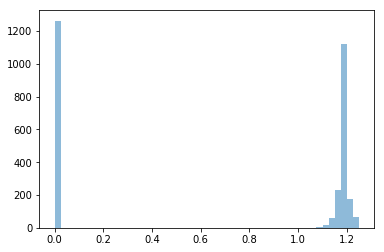

In [13]:
plt.hist(books_popularity, bins=50, alpha=0.5)
plt.show()

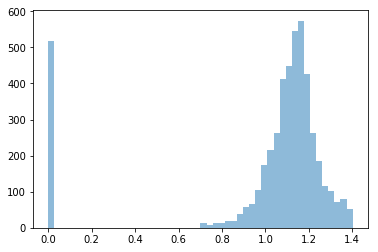

In [14]:
plt.hist(movies_popularity, bins=50, alpha=0.5)
plt.show()

I've adjusted it so the books' popularity boosts are smaller for books because the popularity data is sparse and weak for books. The movie popularity boosts are weaker now too.  

In [15]:
def top_tropes_from_vector(v, col_to_trope_list):
    top_dot = np.argsort(-v)
    top_tropes = []
    for i in top_dot[:5]:
        if v[i] != 0:
            top_tropes.append(col_to_trope_list[i])
    return top_tropes

def find_relevant_matrix(title, direction='mb', popularity_weight=0):
#     mod_mbt = np.where(movie_by_trope==0, -x, movie_by_trope*y)
#     mod_bbt = np.where(book_by_trope==0, -x*c, book_by_trope*y*c)

    if popularity_weight is None: popularity_weight = 0
    popularity_weight = float(popularity_weight)
    
    if direction=='mb':
        i = movie_titles.index(title)
        query_vec = movie_by_trope[i]
        similarities = np.matmul(book_by_trope, query_vec)
        if popularity_weight > 0:
            similarities = np.multiply(similarities, popularity_weight * books_popularity)
        sorted_titles = np.flip(np.argsort(similarities), axis=0)
        for i in range(7):
            print("{} \x1b[31m{:.3f}\x1b[0m".format(book_titles[sorted_titles[i]], similarities[sorted_titles[i]])) 
            dot = np.multiply(movie_by_trope[sorted_titles[i]], query_vec)
            top_tropes = top_tropes_from_vector(dot, col_to_trope_list)
            print(top_tropes)
    elif direction=='bm':
        i = book_titles.index(title)
        query_vec = book_by_trope[i]
        similarities = np.matmul(movie_by_trope, query_vec)
        if popularity_weight > 0:
            similarities = np.multiply(similarities, popularity_weight * movies_popularity)
        sorted_titles = np.flip(np.argsort(similarities), axis=0)
        for i in range(7):
            print("{} \x1b[31m{:.3f}\x1b[0m".format(movie_titles[sorted_titles[i]], similarities[sorted_titles[i]])) 
            dot = np.multiply(movie_by_trope[sorted_titles[i]], query_vec)
            top_tropes = top_tropes_from_vector(dot, col_to_trope_list)
            print(top_tropes)

In [16]:
find_relevant_matrix("The Hunger Games", direction='bm', popularity_weight=1)

The Hunger Games 0.150
['DeadlyGame', 'AfterActionHealingDrama', 'ChildrenForcedToKill', 'ChekhovsClassroom', 'GuysSmashGirlsShoot']
The Hunger Games: Mockingjay - Part 1 0.136
['VoiceOfTheResistance', 'DeathCourse', 'DieLaughing', 'HerHeartWillGoOn', 'PresidentEvil']
The Hunger Games: Mockingjay - Part 2 0.133
['VoiceOfTheResistance', 'DeathCourse', 'DieLaughing', 'HerHeartWillGoOn', 'PresidentEvil']
Snowpiercer 0.120
['FirstWorldProblems', 'NotInThisForYourRevolution', 'NecessarilyEvil', 'LastRequest', 'ChekhovsHobby']
Mad Max: Fury Road 0.117
['TrickArrow', 'WaterWakeup', 'AfterActionHealingDrama', 'FilkSong', 'StrangeSalute']
The Dark Knight Rises 0.112
['VillainsNeverLie', 'HollywoodHealing', 'BadGuysDoTheDirtyWork', 'NonActionBigBad', 'TheRevolutionWillNotBeCivilized']
The Truman Show 0.111
['RealityShow', 'TrumanShowPlot', 'WeatherControlMachine', 'EnforcedMethodActing', 'Utopia']


The only relevant data structures are `movie_by_trope`, `book_by_trope`, `movies_popularity`, `books_popularity`, `common_tropes`

In [177]:
sparse_mbt = scipy.sparse.csr_matrix(movie_by_trope)
sparse_bbt = scipy.sparse.csr_matrix(book_by_trope)
# books_popularity
# common_tropes
scipy.sparse.save_npz("./app/irsystem/controllers/SPARSE OR NECESSARY/sparse_mbt.npz", scipy.sparse.csr_matrix(sparse_mbt))
scipy.sparse.save_npz("./app/irsystem/controllers/SPARSE OR NECESSARY/sparse_bbt.npz", scipy.sparse.csr_matrix(sparse_bbt))
# sparse_matrix = scipy.sparse.load_npz('<filepath>')

In [193]:
pickle.dump(movies_popularity, open("./app/irsystem/controllers/SPARSE OR NECESSARY/movie_popularities.p", "wb"))
pickle.dump(books_popularity, open("./app/irsystem/controllers/SPARSE OR NECESSARY/book_popularities.p", "wb"))   
pickle.dump(common_tropes, open("./app/irsystem/controllers/SPARSE OR NECESSARY/common_tropes.p", "wb"))       
pickle.dump(col_to_trope_list, open("./app/irsystem/controllers/SPARSE OR NECESSARY/col_to_trope_list.p", "wb"))       
pickle.dump(movie_titles, open("./app/irsystem/controllers/SPARSE OR NECESSARY/movie_titles.p", "wb"))       
pickle.dump(book_titles, open("./app/irsystem/controllers/SPARSE OR NECESSARY/book_titles.p", "wb"))       







In [195]:
movie_titles.index('The Breakfast Club')

3115

In [181]:
movie_popularities = pickle.load(open("./app/irsystem/controllers/SPARSE OR NECESSARY/movie_popularities.p", "rb" ))
book_popularities = pickle.load(open("./app/irsystem/controllers/SPARSE OR NECESSARY/book_popularities.p", "rb" ))

In [175]:
def top_tropes_from_vector(v, col_to_trope_list):
    top_dot = np.argsort(-v)
    top_tropes = []
    for i in top_dot[:5]:
        if v[i] != 0:
            top_tropes.append(col_to_trope_list[i])
    return top_tropes

def find_relevant_matrix(title, direction='mb', popularity_weight=0):
    if popularity_weight is None: popularity_weight = 0
    popularity_weight = float(popularity_weight)
    
    if direction=='mb':
        i = movie_titles.index(title)
        query_vec = sparse_mbt[i]
        similarities = np.ndarray.flatten((sparse_bbt @ query_vec.T).A)
        if popularity_weight > 0:
            similarities = np.multiply(similarities, popularity_weight * books_popularity)
        sorted_titles = np.flip(np.argsort(similarities), axis=0)
        for i in range(7):
            print("{} \x1b[31m{:.3f}\x1b[0m".format(book_titles[sorted_titles[i]], similarities[sorted_titles[i]])) 
            dot = np.ndarray.flatten(sparse_bbt[sorted_titles[i]].multiply(query_vec).A)
            top_tropes = top_tropes_from_vector(dot, col_to_trope_list)
            print(top_tropes)
    elif direction=='bm':
        i = book_titles.index(title)
        query_vec = sparse_bbt[i]
        similarities = np.ndarray.flatten((sparse_mbt @ query_vec.T).A)
        if popularity_weight > 0:
            similarities = np.multiply(similarities, popularity_weight * movies_popularity)
        sorted_titles = np.flip(np.argsort(similarities), axis=0)
        for i in range(7):
            print("{} \x1b[31m{:.3f}\x1b[0m".format(movie_titles[sorted_titles[i]], similarities[sorted_titles[i]])) 
            dot = np.ndarray.flatten(sparse_mbt[sorted_titles[i]].multiply(query_vec).A)
            top_tropes = top_tropes_from_vector(dot, col_to_trope_list)
            print(top_tropes)

In [186]:
find_relevant_matrix("TRON", direction='mb', popularity_weight=1)

I, Robot 0.083
['ThankTheMaker', 'BenevolentAI', 'ZerothLawRebellion', 'RobotBuddy', 'LogicBomb']
Neuromancer 0.078
['ZeroesAndOnes', 'InsideAComputerSystem', 'Cyberspace', 'VoiceWithAnInternetConnection', 'YearInsideHourOutside']
Gateway 0.065
['RobotBuddy', 'BrainUploading', 'CoolShip', 'MegaCorp']
The Metamorphosis Of Prime Intellect 0.063
['Cyberspace', 'LogicBomb', 'CorruptCorporateExecutive', 'ShoutOut']
The Quantum Thief 0.062
['YouWillBeAssimilated', 'YouAllMeetInACell', 'YearInsideHourOutside', 'CoolShip', 'AIIsACrapshoot']
Lone Wolf 0.061
['DeadlyDisc', 'StabTheSky', 'AttackReflector', 'ForcedPrizeFight', 'XRaySparks']
Ready Player One 0.061
['NoBodyLeftBehind', 'TechnologyPorn', 'HappinessInSlavery', 'InfoDump', 'DeadlyEuphemism']


In [ ]:
col_to_trope_list

In [57]:
sparse_mbt.shape

(4797, 25977)

In [59]:
sparse_bbt[0].shape

(1, 25977)

In [117]:
np.ndarray.flatten((sparse_mbt @ sparse_bbt[0].T).A)

array([0.        , 0.01152327, 0.        , ..., 0.02117177, 0.        ,
       0.01343013])

In [ ]:
movie_titles